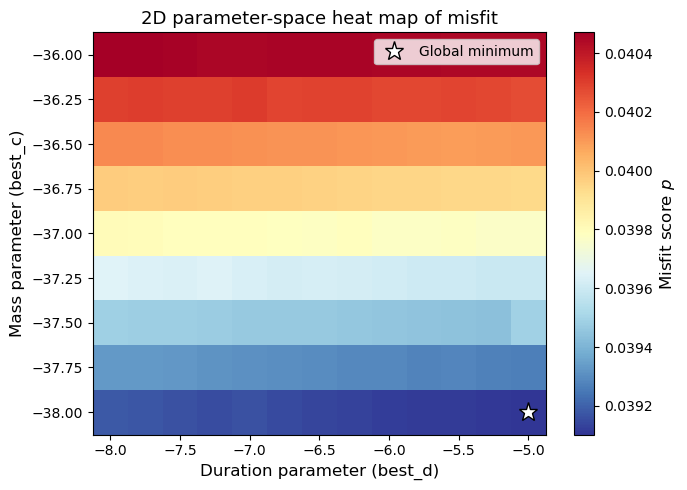

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 读入汇总 CSV
df = pd.read_csv("p_summary3.csv")

# ===== 在这里选择你想做成二维图的两个参数 =====
# 比如下例：x = best_d（持续时间），y = best_c（碳总量），颜色 = best_p（误差）
x_col = "folder_param1"
y_col = "folder_param2"
z_col = "best_p"

# 2. 把散点数据整理成规则网格：行 = y, 列 = x，值 = z
#    如果同一个 (x,y) 有多行，就取最小的 p（你也可以改成 'mean' 等）
pivot = df.pivot_table(index=y_col,
                       columns=x_col,
                       values=z_col,
                       aggfunc="min")

# 网格坐标
x_vals = pivot.columns.to_numpy()      # 唯一 x
y_vals = pivot.index.to_numpy()       # 唯一 y
X, Y = np.meshgrid(x_vals, y_vals)    # 生成网格
Z = pivot.to_numpy()                  # 对应的 z 值

# 3. 画二维参数空间热图
fig, ax = plt.subplots(figsize=(7, 5))

# 用 pcolormesh 画伪彩色图（和示例图类似）
pcm = ax.pcolormesh(X, Y, Z,
                    shading="auto",
                    cmap = 'RdYlBu_r')   # 避免维度不匹配的告警

# 颜色条
cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label("Misfit score $p$", fontsize=12)

# 坐标轴标签（按你的物理量改）
ax.set_xlabel("Duration parameter (best_d)", fontsize=12)
ax.set_ylabel("Mass parameter (best_c)", fontsize=12)

# 4. 额外：标出全局最小 p 的位置（白色星号）
idx_min = df[z_col].idxmin()
x_min = df.loc[idx_min, x_col]
y_min = df.loc[idx_min, y_col]
ax.plot(x_min, y_min,
        marker="*",
        markersize=14,
        markeredgecolor="k",
        markerfacecolor="w",
        linestyle="none",
        label="Global minimum")

ax.legend(loc="best", frameon=True)
ax.set_title("2D parameter-space heat map of misfit", fontsize=13)

plt.tight_layout()
plt.show()


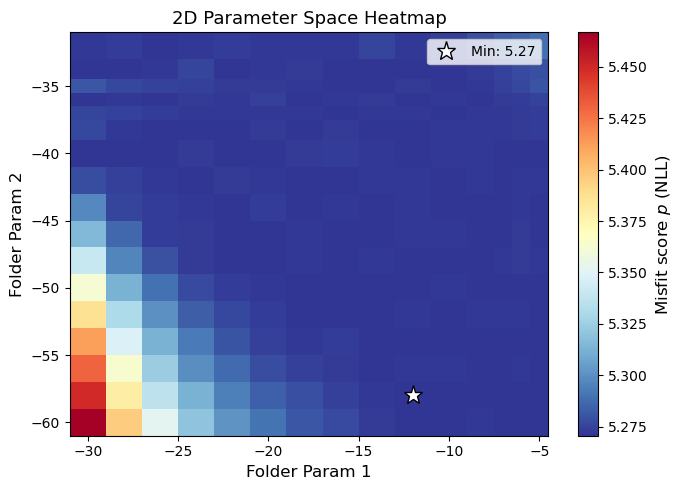

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 读入汇总 CSV
df = pd.read_csv("summary_optimized_T_CO2.csv")

# 提取参数
pattern = r'(-?[\d\.]+)_(-?[\d\.]+)'
parsed_params = df['folder'].astype(str).str.extract(pattern)

# 将提取出来的字符串转换为浮点数
df['parsed_p1'] = pd.to_numeric(parsed_params[0], errors='coerce')
df['parsed_p2'] = pd.to_numeric(parsed_params[1], errors='coerce')

# 检查是否有解析失败的行
if df[['parsed_p1', 'parsed_p2']].isna().any().any():
    print("警告：部分 folder 格式无法解析，已标记为 NaN")

# %% 过滤掉 NaN 数据，创建绘图专用 DataFrame
valid_mask = df['param1'].notna() & df['param2'].notna() & df['Total_NLL'].notna()
plot_data = df[valid_mask].copy()

# 定义列名变量（字符串）
x_col_name = 'param1'
y_col_name = 'param2'
z_col_name = 'Total_NLL'

# 2. 【修正点】直接在 plot_data 上调用 pivot_table，传入列名字符串
pivot = plot_data.pivot_table(index=y_col_name,
                              columns=x_col_name,
                              values=z_col_name,
                              aggfunc="min")

# 网格坐标
x_vals = pivot.columns.to_numpy()       # 唯一 x
y_vals = pivot.index.to_numpy()         # 唯一 y
X, Y = np.meshgrid(x_vals, y_vals)      # 生成网格
Z = pivot.to_numpy()                    # 对应的 z 值

# 3. 画二维参数空间热图
fig, ax = plt.subplots(figsize=(7, 5))

# 用 pcolormesh 画伪彩色图
pcm = ax.pcolormesh(X, Y, Z,
                    shading="auto",
                    cmap='RdYlBu_r')

# 颜色条
cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label("Misfit score $p$ (NLL)", fontsize=12)

# 坐标轴标签
ax.set_xlabel("Folder Param 1", fontsize=12)
ax.set_ylabel("Folder Param 2", fontsize=12)

# 4. 【修正点】标出全局最小 p 的位置
# 获取最小值所在的行
min_row = plot_data.loc[plot_data[z_col_name].idxmin()]
x_min = min_row[x_col_name]
y_min = min_row[y_col_name]

ax.plot(x_min, y_min,
        marker="*",
        markersize=14,
        markeredgecolor="k",
        markerfacecolor="w",
        linestyle="none",
        label=f"Min: {min_row[z_col_name]:.2f}")

ax.legend(loc="best", frameon=True)
ax.set_title("2D Parameter Space Heatmap", fontsize=13)

plt.tight_layout()
plt.show()

----------------------------------------
BEST RESULTS SUMMARY
----------------------------------------
1. Best fit for CO2:
   - Ratio (CO2/CH4): 1.2353
   - NLL Score:       5.2061

2. Best fit for SST (Temperature):
   - Ratio (CO2/CH4): 1.0909
   - NLL Score:       0.0644
----------------------------------------


C:\Users\Windows11\AppData\Local\Temp\ipykernel_15856\3077958689.py:89: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


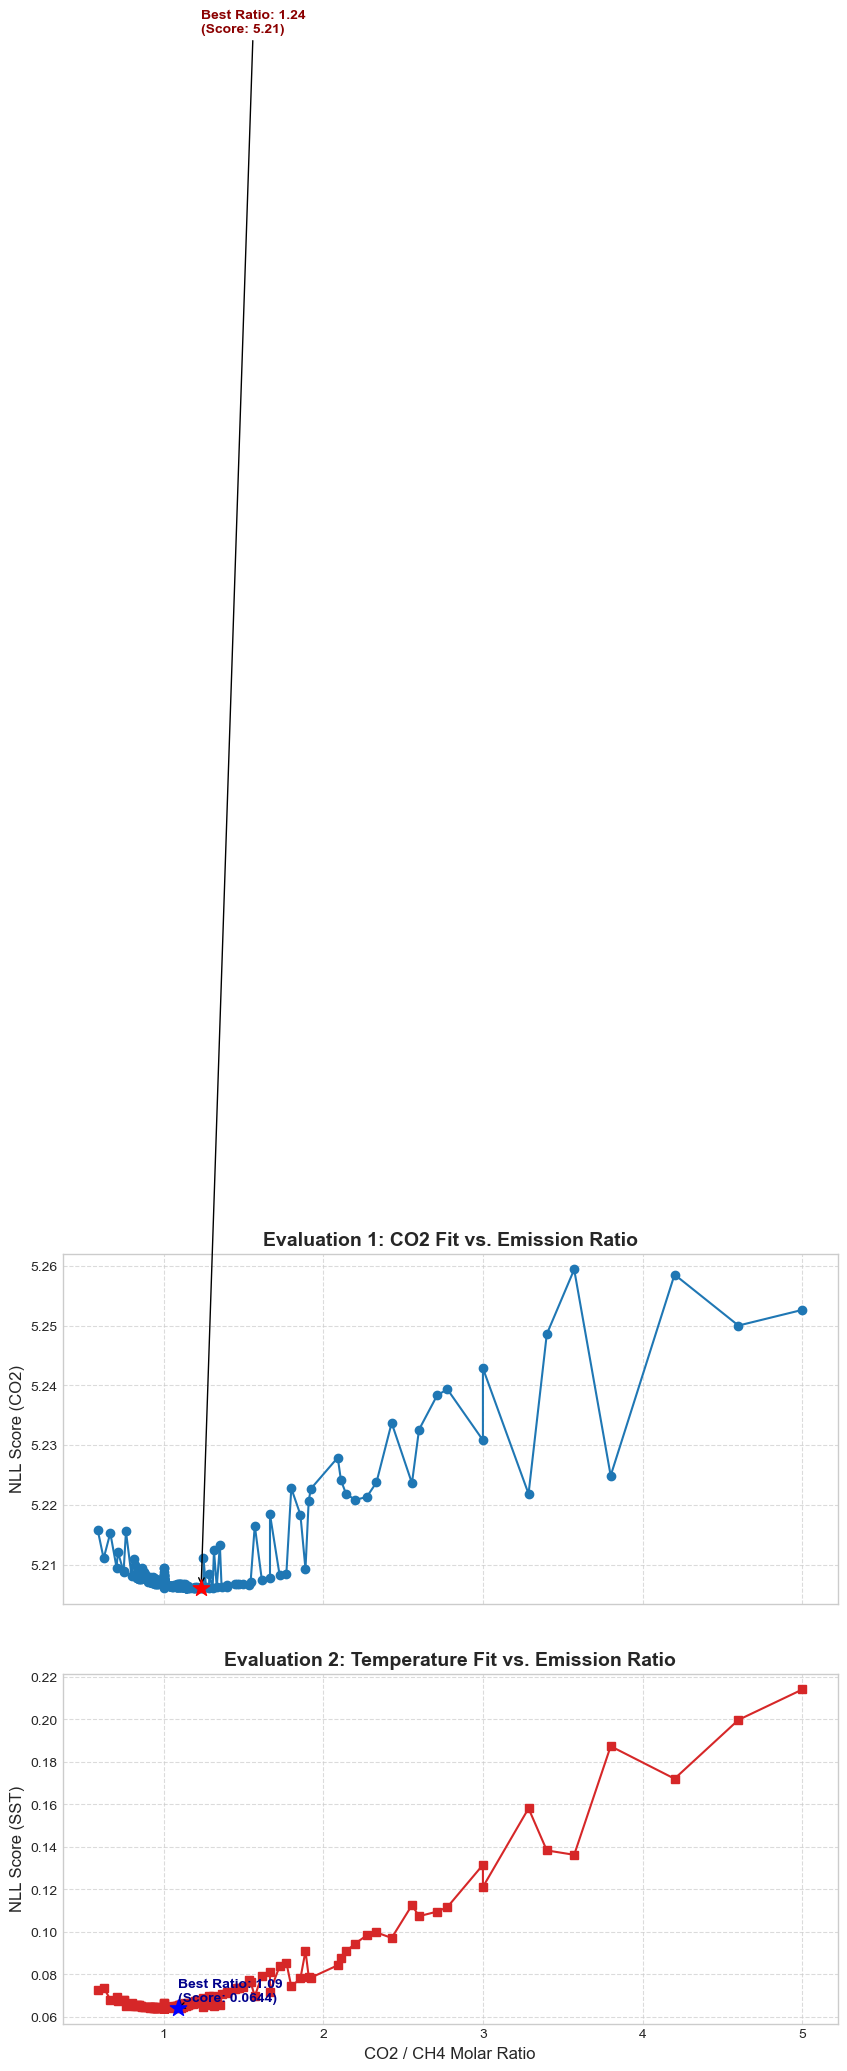

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')

def plot_carbon_trends_english(file_path):
    # 1. Load Data
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return

    # 2. Calculate Ratios
    # Formula: c_val = f_co2 * param1 + (1 - f_co2) * param2
    # f_co2 = (c_val - param2) / (param1 - param2)
    # Added 1e-9 to avoid division by zero
    df['f_co2'] = (df['c_val'] - df['param2']) / (df['param1'] - df['param2'] + 1e-9)
    
    # Filter valid range (0 to 1) to avoid physical impossibilities
    # You can comment this out if you want to see all mathematical results
    df = df[(df['f_co2'] >= 0) & (df['f_co2'] <= 1)].copy()

    # Calculate Molar Ratio: CO2 / CH4
    df['ratio'] = df['f_co2'] / (1 - df['f_co2'] + 1e-9)

    # 3. Sort by Ratio (Crucial for line plots)
    df_sorted = df.sort_values(by='ratio')

    # 4. Find Best Performers (Minimum NLL)
    # For CO2
    best_co2_idx = df_sorted['NLL_CO2'].idxmin()
    best_co2_row = df_sorted.loc[best_co2_idx]
    
    # For SST
    best_sst_idx = df_sorted['NLL_SST'].idxmin()
    best_sst_row = df_sorted.loc[best_sst_idx]

    # Print results to console
    print("-" * 40)
    print("BEST RESULTS SUMMARY")
    print("-" * 40)
    print(f"1. Best fit for CO2:")
    print(f"   - Ratio (CO2/CH4): {best_co2_row['ratio']:.4f}")
    print(f"   - NLL Score:       {best_co2_row['NLL_CO2']:.4f}")
    print(f"\n2. Best fit for SST (Temperature):")
    print(f"   - Ratio (CO2/CH4): {best_sst_row['ratio']:.4f}")
    print(f"   - NLL Score:       {best_sst_row['NLL_SST']:.4f}")
    print("-" * 40)

    # 5. Plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

    # --- Plot 1: CO2 Assessment ---
    ax1.plot(df_sorted['ratio'], df_sorted['NLL_CO2'], 'o-', color='#1f77b4', label='NLL_CO2')
    # Mark the best point
    ax1.scatter(best_co2_row['ratio'], best_co2_row['NLL_CO2'], color='red', s=150, zorder=5, marker='*')
    
    # Annotation
    ax1.annotate(f"Best Ratio: {best_co2_row['ratio']:.2f}\n(Score: {best_co2_row['NLL_CO2']:.2f})",
                 xy=(best_co2_row['ratio'], best_co2_row['NLL_CO2']),
                 xytext=(best_co2_row['ratio'], best_co2_row['NLL_CO2'] * 1.05), # Position text slightly above
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 fontsize=10, fontweight='bold', color='darkred')
    
    ax1.set_ylabel('NLL Score (CO2)', fontsize=12)
    ax1.set_title('Evaluation 1: CO2 Fit vs. Emission Ratio', fontsize=14, fontweight='bold')
    ax1.grid(True, linestyle='--', alpha=0.7)

    # --- Plot 2: SST Assessment ---
    ax2.plot(df_sorted['ratio'], df_sorted['NLL_SST'], 's-', color='#d62728', label='NLL_SST')
    # Mark the best point
    ax2.scatter(best_sst_row['ratio'], best_sst_row['NLL_SST'], color='blue', s=150, zorder=5, marker='*')
    
    # Annotation
    ax2.annotate(f"Best Ratio: {best_sst_row['ratio']:.2f}\n(Score: {best_sst_row['NLL_SST']:.4f})",
                 xy=(best_sst_row['ratio'], best_sst_row['NLL_SST']),
                 xytext=(best_sst_row['ratio'], best_sst_row['NLL_SST'] * 1.05),
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 fontsize=10, fontweight='bold', color='darkblue')

    ax2.set_ylabel('NLL Score (SST)', fontsize=12)
    ax2.set_xlabel('CO2 / CH4 Molar Ratio', fontsize=12)
    ax2.set_title('Evaluation 2: Temperature Fit vs. Emission Ratio', fontsize=14, fontweight='bold')
    ax2.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

plot_carbon_trends_english('summary_optimized_T_CO2.csv')


           基于【均值】的鲁棒性评估结果
数据总行数: 255
合并后的不同比例组数: 85
------------------------------
【平均表现最佳的排放比例】: 1.06 : 1
   - 综合得分均值 (越低越好): -0.7023
   - 该组样本数量: 1
   - CO2 平均 Z-Score: -0.3863
   - SST 平均 Z-Score: -0.3160
------------------------------


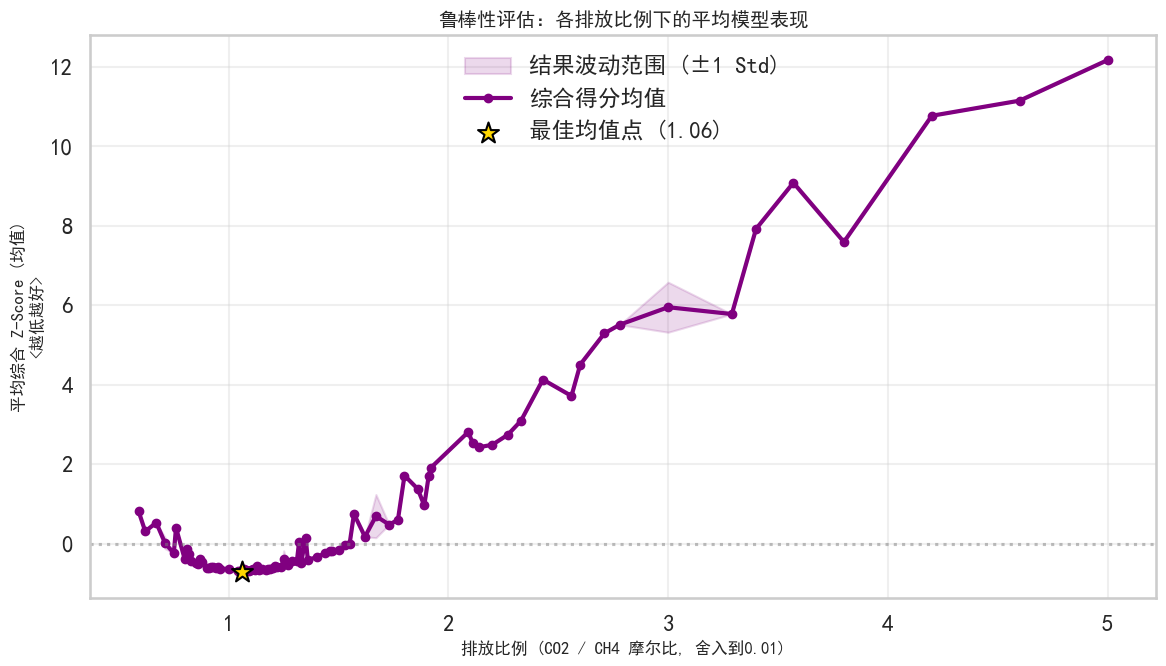

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# =================配置区域=================
FILE_PATH = 'summary_optimized_T_CO2.csv'
# =========================================

sns.set(style="whitegrid", context="talk")
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

def solve_robust_scenario():
    # 1. 读取数据
    try:
        df = pd.read_csv(FILE_PATH)
    except FileNotFoundError:
        print(f"找不到文件 {FILE_PATH}")
        return

    # 2. 计算比例 (Mixing Model)
    # 增加微小量防止除零
    epsilon = 1e-9
    df['f_co2'] = (df['c_val'] - df['param2']) / (df['param1'] - df['param2'] + epsilon)
    
    # 过滤无效比例
    df_valid = df[(df['f_co2'] >= 0) & (df['f_co2'] <= 1)].copy()
    
    # 计算摩尔比
    df_valid['ratio_molar'] = df_valid['f_co2'] / (1 - df_valid['f_co2'] + epsilon)

    # 3. Z-Score 标准化 (对原始单次运行进行评分)
    mu_co2, sig_co2 = df_valid['NLL_CO2'].mean(), df_valid['NLL_CO2'].std()
    mu_sst, sig_sst = df_valid['NLL_SST'].mean(), df_valid['NLL_SST'].std()
    
    df_valid['Z_CO2'] = (df_valid['NLL_CO2'] - mu_co2) / sig_co2
    df_valid['Z_SST'] = (df_valid['NLL_SST'] - mu_sst) / sig_sst
    df_valid['Score_Combined'] = df_valid['Z_CO2'] + df_valid['Z_SST']

    # =========================================================
    # 4. 【核心修改】分组聚合 (Binning & Aggregation)
    # =========================================================
    
    # 步骤 A: 将比例四舍五入到小数点后 2 位，作为“组”的标签
    # 例如：1.001 和 0.999 都会变成 1.00
    df_valid['ratio_bin'] = df_valid['ratio_molar'].round(2)
    
    # 步骤 B: 按组计算均值、标准差、样本数
    # 我们不仅看 Mean (平均水平)，也看 Std (不确定性)
    df_grouped = df_valid.groupby('ratio_bin').agg({
        'Score_Combined': ['mean', 'std', 'count'],
        'Z_CO2': 'mean',
        'Z_SST': 'mean'
    }).reset_index()
    
    # 重命名列以便访问
    df_grouped.columns = ['ratio_bin', 'Score_Mean', 'Score_Std', 'Count', 'Z_CO2_Mean', 'Z_SST_Mean']
    
    # 过滤掉样本数过少的组 (可选，比如只看至少跑了 2 次以上的比例)
    # df_grouped = df_grouped[df_grouped['Count'] >= 2]

    # =========================================================
    # 5. 寻找“平均表现”最佳点
    # =========================================================
    
    # 按均值排序
    best_avg_idx = df_grouped['Score_Mean'].idxmin()
    best_avg_row = df_grouped.loc[best_avg_idx]

    print("\n" + "="*50)
    print("           基于【均值】的鲁棒性评估结果")
    print("="*50)
    print(f"数据总行数: {len(df_valid)}")
    print(f"合并后的不同比例组数: {len(df_grouped)}")
    print("-" * 30)
    print(f"【平均表现最佳的排放比例】: {best_avg_row['ratio_bin']:.2f} : 1")
    print(f"   - 综合得分均值 (越低越好): {best_avg_row['Score_Mean']:.4f}")
    print(f"   - 该组样本数量: {int(best_avg_row['Count'])}")
    print(f"   - CO2 平均 Z-Score: {best_avg_row['Z_CO2_Mean']:.4f}")
    print(f"   - SST 平均 Z-Score: {best_avg_row['Z_SST_Mean']:.4f}")
    print("-" * 30)
    
    # =========================================================
    # 6. 绘图：均值曲线 + 误差阴影
    # =========================================================
    plt.figure(figsize=(12, 7))
    
    x = df_grouped['ratio_bin']
    y = df_grouped['Score_Mean']
    y_err = df_grouped['Score_Std'].fillna(0) # 如果只有一个样本，std为NaN，设为0
    
    # 1. 绘制误差范围 (均值 ± 0.5倍标准差，表示核心分布区)
    # 也就是“大部分模拟结果都落在这个阴影里”
    plt.fill_between(x, y - y_err, y + y_err, color='purple', alpha=0.15, label='结果波动范围 (±1 Std)')
    
    # 2. 绘制均值曲线
    plt.plot(x, y, color='purple', linewidth=3, marker='o', markersize=6, label='综合得分均值')
    
    # 3. 标记最佳点
    plt.scatter(best_avg_row['ratio_bin'], best_avg_row['Score_Mean'], 
                color='gold', s=250, marker='*', edgecolors='black', zorder=10, 
                label=f"最佳均值点 ({best_avg_row['ratio_bin']})")

    # 4. 辅助线和标签
    plt.axhline(0, color='gray', linestyle=':', alpha=0.5)
    plt.xlabel('排放比例 (CO2 / CH4 摩尔比, 舍入到0.01)', fontsize=12)
    plt.ylabel('平均综合 Z-Score (均值)\n<越低越好>', fontsize=12)
    plt.title('鲁棒性评估：各排放比例下的平均模型表现', fontsize=14)
    
    # 在图上标出每个点的样本数(可选)
    # for i, row in df_grouped.iterrows():
    #     plt.text(row['ratio_bin'], row['Score_Mean'], int(row['Count']), fontsize=9, ha='center', va='bottom')

    plt.legend(loc='upper center')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 运行
solve_robust_scenario()


Optimal Emission Ratio: 1.26 : 1
   - Mean Combined Score: -0.7163
------------------------------
Figure saved as Robustness_Assessment_Plot_04.pdf


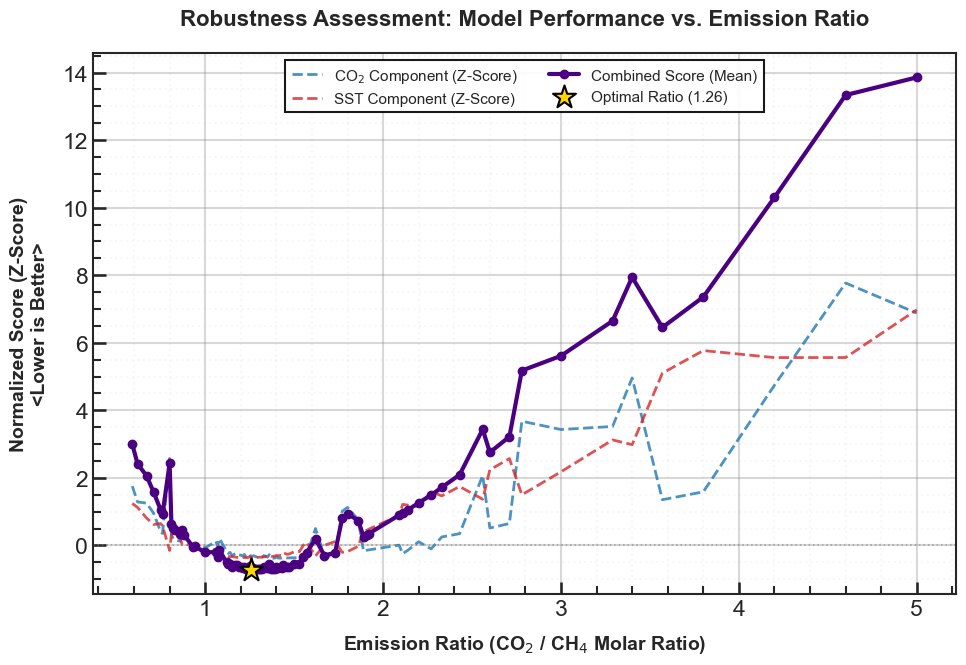

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ================= CONFIG =================
FILE_PATH = 'summary_optimized_T_CO2.csv'
OUTPUT_FILENAME = 'Robustness_Assessment_Plot_04.pdf'
# =========================================

# Set publication style
# 'ticks' style is cleaner for scientific plots
sns.set(style="ticks", context="talk") 

# Configure fonts and line weights for publication quality
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Helvetica']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['pdf.fonttype'] = 42  # Ensure fonts are editable in Illustrator/Inkscape
plt.rcParams['ps.fonttype'] = 42

def solve_robust_scenario():
    # 1. Load Data
    try:
        df = pd.read_csv(FILE_PATH)
    except FileNotFoundError:
        print(f"File not found: {FILE_PATH}")
        return

    # 2. Mixing Model Calculation
    epsilon = 1e-9
    df['f_co2'] = (df['c_val'] - df['param2']) / (df['param1'] - df['param2'] + epsilon)
    
    # Filter valid ratios
    df_valid = df[(df['f_co2'] >= 0) & (df['f_co2'] <= 1)].copy()
    
    # Calculate Molar Ratio
    df_valid['ratio_molar'] = df_valid['f_co2'] / (1 - df_valid['f_co2'] + epsilon)

    # 3. Z-Score Standardization
    mu_co2, sig_co2 = df_valid['NLL_CO2'].mean(), df_valid['NLL_CO2'].std()
    mu_sst, sig_sst = df_valid['NLL_SST'].mean(), df_valid['NLL_SST'].std()
    
    df_valid['Z_CO2'] = (df_valid['NLL_CO2'] - mu_co2) / sig_co2
    df_valid['Z_SST'] = (df_valid['NLL_SST'] - mu_sst) / sig_sst
    df_valid['Score_Combined'] = df_valid['Z_CO2'] + df_valid['Z_SST']

    # =========================================================
    # 4. Binning & Aggregation
    # =========================================================
    df_valid['ratio_bin'] = df_valid['ratio_molar'].round(2)
    
    df_grouped = df_valid.groupby('ratio_bin').agg({
        'Score_Combined': ['mean', 'std', 'count'],
        'Z_CO2': 'mean',
        'Z_SST': 'mean'
    }).reset_index()
    
    # Rename columns
    df_grouped.columns = ['ratio_bin', 'Score_Mean', 'Score_Std', 'Count', 'Z_CO2_Mean', 'Z_SST_Mean']
    
    # Find Optimal Point (Minimum Mean Score)
    best_avg_idx = df_grouped['Score_Mean'].idxmin()
    best_avg_row = df_grouped.loc[best_avg_idx]

    print("\n" + "="*50)
    print(f"Optimal Emission Ratio: {best_avg_row['ratio_bin']:.2f} : 1")
    print(f"   - Mean Combined Score: {best_avg_row['Score_Mean']:.4f}")
    print("-" * 30)
    
    # =========================================================
    # 5. Plotting: Publication Standard
    # =========================================================
    fig, ax = plt.subplots(figsize=(10, 7))
    
    x = df_grouped['ratio_bin']
    y = df_grouped['Score_Mean']
    y_err = df_grouped['Score_Std'].fillna(0)
    
    # Color Palette (Scientific & Colorblind-friendly)
    color_combined = '#4B0082'  # Indigo
    color_co2 = '#1f77b4'       # Blue
    color_sst = '#d62728'       # Red

    # 1. Error Band (Uncertainty)
    # 2. Component Lines (Dashed)
    ax.plot(x, df_grouped['Z_CO2_Mean'], color=color_co2, linestyle='--', linewidth=2, 
            label=r'CO$_2$ Component (Z-Score)', alpha=0.8)
    
    ax.plot(x, df_grouped['Z_SST_Mean'], color=color_sst, linestyle='--', linewidth=2, 
            label='SST Component (Z-Score)', alpha=0.8)

    # 3. Main Combined Score (Solid)
    ax.plot(x, y, color=color_combined, linewidth=3, marker='o', markersize=6, 
            label='Combined Score (Mean)', zorder=5)
    
    # 4. Optimal Point Marker
    ax.scatter(best_avg_row['ratio_bin'], best_avg_row['Score_Mean'], 
               color='gold', s=300, marker='*', edgecolors='black', linewidth=1.5, zorder=10, 
               label=f"Optimal Ratio ({best_avg_row['ratio_bin']})")

    # 5. Formatting
    ax.axhline(0, color='gray', linestyle=':', alpha=0.6, linewidth=1.2)
    
    # Labels with LaTeX formatting
    ax.set_xlabel(r'Emission Ratio (CO$_2$ / CH$_4$ Molar Ratio)', fontsize=14, fontweight='bold', labelpad=10)
    ax.set_ylabel('Normalized Score (Z-Score)\n<Lower is Better>', fontsize=14, fontweight='bold', labelpad=10)
    ax.set_title('Robustness Assessment: Model Performance vs. Emission Ratio', fontsize=16, fontweight='bold', pad=20)
    
    # Ticks & Grid
    ax.grid(True, which='major', linestyle='-', alpha=0.3, color='gray')
    ax.minorticks_on()
    ax.grid(True, which='minor', linestyle=':', alpha=0.15)
    
    # Thicken spines
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
        
    # Legend
    ax.legend(loc='upper center', fontsize=11, frameon=True, fancybox=False, 
              edgecolor='black', framealpha=0.9, ncol=2)

    plt.tight_layout()
    
    # 6. Save as PDF (Vector graphic)
    plt.savefig(OUTPUT_FILENAME, dpi=300, bbox_inches='tight', format='pdf')
    print(f"Figure saved as {OUTPUT_FILENAME}")
    
    plt.show()

if __name__ == "__main__":
    solve_robust_scenario()